<a href="https://colab.research.google.com/github/kieranfmaguire/learningdeeplearning/blob/main/notebooks/fine_tune_BERT_on_COLA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finetune BERT model on the Corpus of Linguistic Acceptability (COLA) dataset
---
This is a small dataset with only around 10,000 examples. Each example is a single sentence, and a label indicating whether that sentence is grammatically correct or not.

This is one of the many tasks that make up the General Language Understanding Evaluation (GLUE) benchmark often used for assessing the performance of NLP models.

## Plan
---

According to the BERT paper [here](https://arxiv.org/pdf/1810.04805.pdf), to achieve state of the art scores on almost all of the GLUE tasks, they simply fine tuned the model for 3 epochs (scanning a grid of learning rates and selecting the best). This is feasible even on a free GPU on colab (eg here).

To fine tune the model for classification tasks, they add a single dense layer to the end of the model. The input to the classification layer is the embedding corresponding to the special input token `[CLS]`, which can be found at the first position of the sequence outputs of the model. The authors also claim that finetuning just the classification layer still achieved very good results at a lower computational cost. Therefore I will try both methods here. 

To save time, I will only use a single learning rate. `1e-3` for the version where BERT weights are frozen, and `1e-5` when training jointly.

To that end, I will do the following:

1. Use pre-trained BERT with a single classification layer to classify the COLA problem, only training the new layer (do not fine tune entire BERT model).

2. Use pre-trained BERT with single classifications layer to classify, allowing the full BERT model parameters to be fine tuned. 

3. Compare the two models

## NOTES
---
It is best to run this on GPU, otherwise training is painfully slow. On GPU, the training shouldn't take much longer than 15 minutes or so.

In [30]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
try:
  import tensorflow_text as text
except:
  !pip install -q tensorflow_text # restart runtime if needed to install
  import tensforflow_text as text
  print("Restart runtime to import tensorflow_text")

### Set up parameters
---
 - Note that I am not using the large BERT.
 - Note the name of the dataset is from the list of available datasets [here](https://www.tensorflow.org/datasets/catalog/overview#text)

In [31]:
# parameters used in the notebook

batch_size = 32               # batch size for fine tuning
data_set_name = 'glue/cola'   # availale from tensorflow_datasets
learning_rate_fast = 1e-3     # for just tuning new layer
learning_rate_slow = 1e-5     # for fine tuning all layes

BERT_URL = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3'       # BERT model to use
BERT_PREPROCESS_URL = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1' # Matching preprocess fn


## Load data and so some preprocessing
---
`tensorflow_datasets` contains utilities for collecting common datasets.

There is not much preprocessing required, since BERT comes with an accompanying preprocessor which uses correct vocabulary and tokenising scheme for BERT. It also creates the two extra masks required for training; word masks and sentence masks aka segment id. Since this task involves single sentences only, there is no need to adjust the segment id (we would need to do extra processing for some other tasks involving multiple sentences)


In [32]:
# load the data using handy tensorflow_datasets package
(cola_train, cola_valid, cola_test), info = tfds.load(data_set_name,                  
                                                      split=['train','validation','test'],
                                                      with_info=True,
                                                      )

In [33]:
# look at the metadata
print(info)

tfds.core.DatasetInfo(
    name='glue',
    version=1.0.0,
    description='GLUE, the General Language Understanding Evaluation benchmark
(https://gluebenchmark.com/) is a collection of resources for training,
evaluating, and analyzing natural language understanding systems.',
    homepage='https://nyu-mll.github.io/CoLA/',
    features=FeaturesDict({
        'idx': tf.int32,
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'sentence': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=10657,
    splits={
        'test': 1063,
        'train': 8551,
        'validation': 1043,
    },
    supervised_keys=None,
    citation="""@article{warstadt2018neural,
      title={Neural Network Acceptability Judgments},
      author={Warstadt, Alex and Singh, Amanpreet and Bowman, Samuel R},
      journal={arXiv preprint arXiv:1805.12471},
      year={2018}
    }
    @inproceedings{wang2019glue,
      title={{GLUE}: A Multi-Task Benchmark and Analysis Platfo

In [34]:
# look at the structure tfds provides the data in
isinstance(cola_train, tf.data.Dataset)
for example in cola_train.take(1):
  print(example['sentence'])
  print(example['label'])

tf.Tensor(b'It is this hat that it is certain that he was wearing.', shape=(), dtype=string)
tf.Tensor(1, shape=(), dtype=int64)


In [35]:
# minimal preprocessing - just extract the sentence and the label, shuffle, batch and prefetch
cola_train = cola_train.map(lambda x: (x['sentence'], x['label']))\
  .shuffle(int(1e3))\
  .batch(32)\
  .prefetch(tf.data.experimental.AUTOTUNE)
cola_valid = cola_valid.map(lambda x: (x['sentence'], x['label']))\
  .batch(32)\
  .prefetch(tf.data.experimental.AUTOTUNE)
cola_test = cola_test.map(lambda x: (x['sentence'], x['label']))\
  .batch(32)\
  .prefetch(tf.data.experimental.AUTOTUNE)

# have a look to make sure it looks okay
for ex in cola_train.take(1):
  print(ex)


(<tf.Tensor: shape=(32,), dtype=string, numpy=
array([b'How do you think John bought what?',
       b'Aloe may have an analgesic effect on inflammation and minor skin irritations.',
       b'Do you know the boy who Mary saw?',
       b'the barge piled high with logs.', b'Sincerity examined a book.',
       b'That Plato lived in the city of Athens was well-known.',
       b'John put in the box.', b'Bill floated into the cave.',
       b'Should not Mary taste the soup?', b'the girls likes themselves.',
       b'We expect them to examine themselves.',
       b'John was seeing his children.',
       b'What did Bill cook supper and wash?',
       b'The Dodgers beat the Red Sox and the Dodgers were beaten by the Giants.',
       b'He analysis her was flawed',
       b'This girl will not buy bread, will she buy bread?',
       b'We rummaged through the desk for papers.',
       b'Anne astonished her father.',
       b'John sang a song and danced to the music.',
       b'Poseidon was asleep, w

## Load the BERT model and create our model for classification
---
The pre-trained model contains ~100M weights, so it will take a couple of minutes to load.

Load BERT and matching preprocessor into a `KerasLayer`, which is the preferred way to load models from tensorflow hub when using the higher level API. For lower level control, use `.load()`

After that, specify the model using the functional API, and compile. We will train it using cross entropy loss: 

$L(y, \hat{y_i}) = \frac{1}{n}\sum_{i=1}^n \,\, - y_i \ln{(\hat{y_i})} - 
(1 - y_i) \ln{(1 - \hat{y_i})}$

Where the $i$ indicates the $i^{th}$ element of the batch. Clearly if correct value is 1, then the loss will be large if $\hat{y}$ is small, and vice versa for the negative class.

The official [GLUE](https://gluebenchmark.com/tasks) benchmarks reports Matthew's Correlation ([wikipedia](https://en.wikipedia.org/wiki/Matthews_correlation_coefficient#:~:text=The%20Matthews%20correlation%20coefficient%20\(MCC,Matthews%20in%201975)), so I also record that value. There is a library function to do so available in `tensorflow_addons`, however it doesn't seem to work correctly, as the value never changes. I haven't looked into it yet - possibly my syntax is just incorrect or something.


In [59]:
# load the BERT model and BERT preprocessor. Use the model which cares about upper/lower case
bert = hub.KerasLayer(BERT_URL, name='BERT', trainable=False)
prep = hub.KerasLayer(BERT_PREPROCESS_URL, name='BERT_PREPROCESSOR', trainable=False)

In [60]:
# create the model using functional API
def create_model_1():
  bert.trainable = False
  prep.trainable = False
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text_input')
  preprocessed_text = prep(text_input)
  bert_out = bert(preprocessed_text)
  cls_token_out = bert_out['sequence_output'][:,0,:]
  # cls_token_out = tf.keras.layers.Lambda(
  #     lambda x: x['sequence_output'][:,0,:], name='get_cls_embedding')(bert_out)
  drop = tf.keras.layers.Dropout(0.3)(cls_token_out)
  out = tf.keras.layers.Dense(units=1, activation='sigmoid', name='output')(drop)

  return tf.keras.Model(inputs=[text_input], outputs=[out])

m1 = create_model_1()
m1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_fast),
          loss=tf.keras.losses.BinaryCrossentropy(),
          metrics=['accuracy', 'AUC', tfa.metrics.F1Score(num_classes=1), tfa.metrics.MatthewsCorrelationCoefficient(num_classes=1)])
m1.summary()


Model: "functional_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         [(None,)]            0                                            
__________________________________________________________________________________________________
BERT_PREPROCESSOR (KerasLayer)  {'input_word_ids': ( 0           text_input[0][0]                 
__________________________________________________________________________________________________
BERT (KerasLayer)               {'sequence_output':  109482241   BERT_PREPROCESSOR[0][0]          
                                                                 BERT_PREPROCESSOR[0][1]          
                                                                 BERT_PREPROCESSOR[0][2]          
______________________________________________________________________________________

## Train the model with BERT weights frozen

In [61]:
history1 = m1.fit(cola_train, epochs=3, validation_data=cola_valid)

Epoch 1/3
268/268 [==============================] - 87s 325ms/step - loss: 0.5951 - accuracy: 0.7031 - auc: 0.6273 - f1_score: 0.8265 - MatthewsCorrelationCoefficient: 0.5934 - val_loss: 0.5415 - val_accuracy: 0.7488 - val_auc: 0.7476 - val_f1_score: 0.8175 - val_MatthewsCorrelationCoefficient: 0.5879
Epoch 2/3
268/268 [==============================] - 89s 334ms/step - loss: 0.5403 - accuracy: 0.7401 - auc: 0.7206 - f1_score: 0.8265 - MatthewsCorrelationCoefficient: 0.5934 - val_loss: 0.5193 - val_accuracy: 0.7536 - val_auc: 0.7657 - val_f1_score: 0.8175 - val_MatthewsCorrelationCoefficient: 0.5879
Epoch 3/3
268/268 [==============================] - 92s 342ms/step - loss: 0.5284 - accuracy: 0.7486 - auc: 0.7398 - f1_score: 0.8265 - MatthewsCorrelationCoefficient: 0.5934 - val_loss: 0.5124 - val_accuracy: 0.7526 - val_auc: 0.7732 - val_f1_score: 0.8175 - val_MatthewsCorrelationCoefficient: 0.5879


## Create and train the second model, where BERT weights are not frozen

In [62]:
# RE-load the BERT model (reset weights)
bert = hub.KerasLayer(BERT_URL, name='BERT', trainable=True)


In [67]:
# now what if we allow all weights in the model to be fine tunes
def create_model_2():
  bert.trainable = True
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text_input')
  preprocessed_text = prep(text_input)
  bert_out = bert(preprocessed_text)
  cls_token_out = tf.keras.layers.Lambda(
      lambda x: x['sequence_output'][:,0,:], name='get_cls_embedding')(bert_out)
  drop = tf.keras.layers.Dropout(0.3)(cls_token_out)
  out = tf.keras.layers.Dense(units=1, activation='sigmoid', name='output')(drop)

  return tf.keras.Model(inputs=[text_input], outputs=[out])

m2 = create_model_2()
m2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_slow),
          loss=tf.keras.losses.BinaryCrossentropy(),
          metrics=['accuracy', 'AUC', tfa.metrics.F1Score(num_classes=1), tfa.metrics.MatthewsCorrelationCoefficient(num_classes=1)])
m2.summary()

Model: "functional_27"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         [(None,)]            0                                            
__________________________________________________________________________________________________
BERT_PREPROCESSOR (KerasLayer)  {'input_mask': (None 0           text_input[0][0]                 
__________________________________________________________________________________________________
BERT (KerasLayer)               {'sequence_output':  109482241   BERT_PREPROCESSOR[2][0]          
                                                                 BERT_PREPROCESSOR[2][1]          
                                                                 BERT_PREPROCESSOR[2][2]          
______________________________________________________________________________________

In [68]:
history2 = m2.fit(cola_train_1, epochs=3, validation_data=cola_valid_1)

Epoch 1/3
268/268 [==============================] - 236s 881ms/step - loss: 0.1914 - accuracy: 0.9268 - auc: 0.9712 - f1_score: 0.8265 - MatthewsCorrelationCoefficient: 0.5934 - val_loss: 0.6156 - val_accuracy: 0.8121 - val_auc: 0.8821 - val_f1_score: 0.8175 - val_MatthewsCorrelationCoefficient: 0.5879
Epoch 2/3
268/268 [==============================] - 242s 901ms/step - loss: 0.1191 - accuracy: 0.9590 - auc: 0.9878 - f1_score: 0.8265 - MatthewsCorrelationCoefficient: 0.5934 - val_loss: 0.6709 - val_accuracy: 0.8178 - val_auc: 0.8685 - val_f1_score: 0.8175 - val_MatthewsCorrelationCoefficient: 0.5879
Epoch 3/3
268/268 [==============================] - 243s 908ms/step - loss: 0.0942 - accuracy: 0.9678 - auc: 0.9919 - f1_score: 0.8265 - MatthewsCorrelationCoefficient: 0.5934 - val_loss: 0.6583 - val_accuracy: 0.8313 - val_auc: 0.8693 - val_f1_score: 0.8175 - val_MatthewsCorrelationCoefficient: 0.5879


## Compare the results for first two models on validation set

In [69]:
hist_1 = pd.DataFrame(history1.history)
hist_2 = pd.DataFrame(history2.history)
hist = hist_1.join(hist_2, lsuffix='_freeze_bert')
# hist.loc[:,[x for x in hist.columns if (x.startswith('loss') | x.startswith('val_loss'))]].plot()


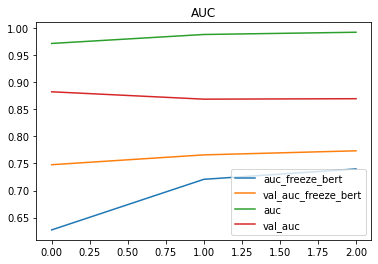

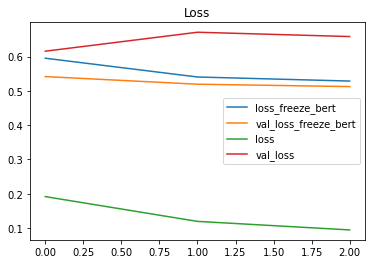

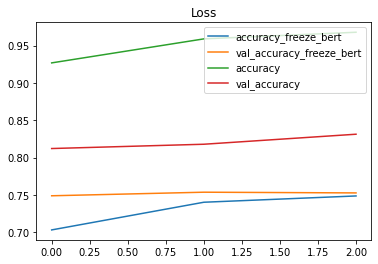

In [71]:
# compare the validation loss, accuracy and AUC for the two models
hist.loc[:, [x for x in hist.columns if (x.startswith('val_auc') | x.startswith('auc'))]].plot(title='AUC')
hist.loc[:, [x for x in hist.columns if (x.startswith('val_loss') | x.startswith('loss'))]].plot(title="Loss")
hist.loc[:, [x for x in hist.columns if (x.startswith('val_acc') | x.startswith('acc'))]].plot(title="Loss")

Looks like if you care more about AUC and accuracy, would choose the full model, but if you care more about cross entropy, you would choose the model where bert is frozen.

I guess this means the freeze bert model is just being more confident in one of the two classes to get the loss score up, but not so good at selecting the bad grammar sentences? Should create a confusion matrix to understand better.

The dataset is not balanced, so be careful when looking at accuracy. (see below)


In [74]:
# check out the balance of the dataset 
labels = []
for _, lab in cola_train.as_numpy_iterator():
    labels += lab.tolist()
labels = pd.DataFrame(labels, columns=['label'])
(labels == 1).sum().values / labels.shape[0], (labels == 0).sum().values / labels.shape[0]

(array([0.70436206]), array([0.29563794]))